## Importando Bibliotecas

In [16]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import tensorflow as tf
import sys
import tensorflow_datasets as tfds # Isso é interessante
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import kagglehub
import warnings
warnings.filterwarnings("ignore")

### Garantindo uso de GPU

In [ ]:
import tensorflow as tf
import os

# Opcional: Esconde logs chatos da CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Configuração para não alocar toda a VRAM de uma vez
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        print(f"✅ GPUs detectadas e configuradas: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"  GPU {i}: {gpu}")
            
    except RuntimeError as e:
        print(e)
else:
    print("❌ Nenhuma GPU detectada. Verifique sua instalação do CUDA/cuDNN.")

Versão do Python: 3.10.19 (main, Oct 10 2025, 08:52:10) [GCC 13.3.0]
Versão do TensorFlow: 2.20.0

✅ SUCESSO! TensorFlow detectou 1 GPU(s):
  - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Detalhes da Build:
OrderedDict([('cpu_compiler', 'clang 18'), ('cuda_compute_capabilities', ['sm_60', 'sm_70', 'sm_80', 'sm_89', 'compute_90']), ('cuda_version', '12.5.1'), ('cudnn_version', '9'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])


## Importando Dataset

In [18]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'eurosat/rgb', 
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,  # Retorna tupla (imagem, label) em vez de dicionário
    with_info=True       # Traz metadados (nomes das classes, etc)
)

## Visualização

In [19]:
class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes

In [20]:
print(f"Número de classes: {num_classes}")
print(f"Nomes das classes: {class_names}")
print("-" * 30)
print(f"Imagens de Treino: {len(ds_train)}")
print(f"Imagens de Validação: {len(ds_val)}")
print(f"Imagens de Teste: {len(ds_test)}")

Número de classes: 10
Nomes das classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
------------------------------
Imagens de Treino: 21600
Imagens de Validação: 2700
Imagens de Teste: 2700


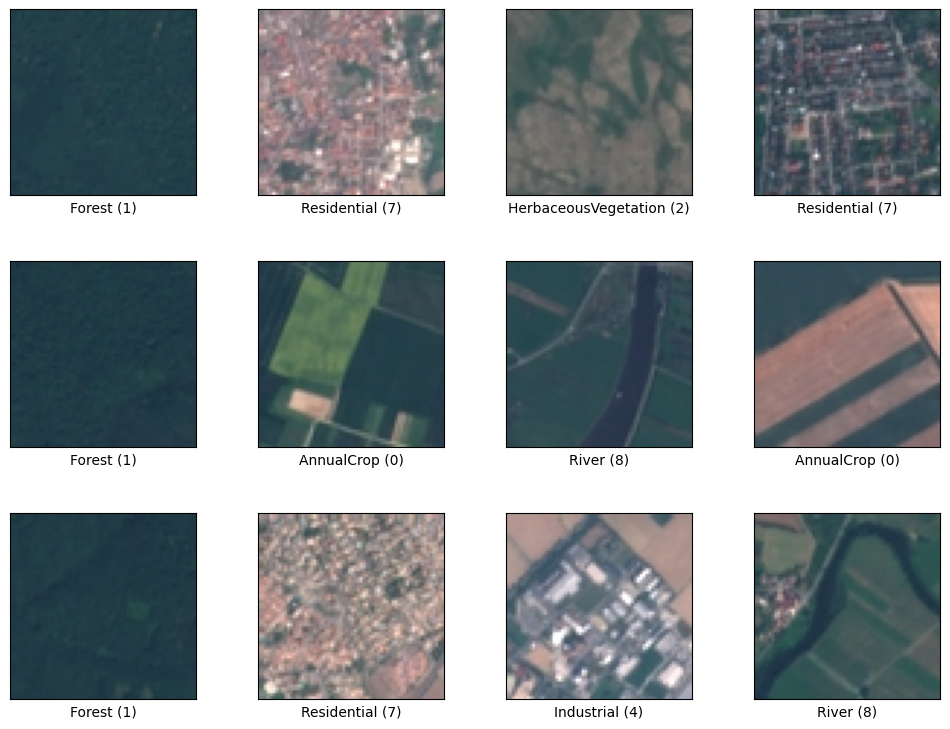

In [21]:
fig = tfds.show_examples(ds_train, ds_info, rows=3, cols=4)
plt.show()

In [22]:
for image, label in ds_train.take(1):
    
    print("=== Análise do Tensor de Imagem ===")
    print(f"Shape (Dimensões): {image.shape}")
    print(f"Data Type (Tipo): {image.dtype}")
    print(f"Valor Mínimo Pixel: {tf.reduce_min(image)}")
    print(f"Valor Máximo Pixel: {tf.reduce_max(image)}")
    
    print("\n=== Análise do Label ===")
    print(f"Valor do Label: {label}")
    print(f"Nome da Classe: {class_names[label]}")

=== Análise do Tensor de Imagem ===
Shape (Dimensões): (64, 64, 3)
Data Type (Tipo): <dtype: 'uint8'>
Valor Mínimo Pixel: 26
Valor Máximo Pixel: 98

=== Análise do Label ===
Valor do Label: 1
Nome da Classe: Forest


## Resize para aplicação de ResNet-50

In [23]:
IMG_SIZE = 224 # tamanho do resnet
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE # Deixa o controle de mémória/CPU para o tensorflow

In [24]:
def preprocess_data(image, label):
    # Redimensionamento 224x224
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    
    # Converter para float32
    image = tf.cast(image, tf.float32)
    
    # Normalização específica da ResNet50V2
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    
    return image, label

In [25]:
train_ds = ds_train.map(preprocess_data, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = ds_val.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = ds_test.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Verificação final do formato que entra na rede
image_batch, label_batch = next(iter(train_ds))
print(f"Formato do Batch de Imagens: {image_batch.shape}")
print(f"Formato do Batch de Labels: {label_batch.shape}")
print(f"Valores agora (Min/Max): {tf.reduce_min(image_batch):.2f} / {tf.reduce_max(image_batch):.2f}")

Formato do Batch de Imagens: (32, 224, 224, 3)
Formato do Batch de Labels: (32,)
Valores agora (Min/Max): -0.87 / 1.00


## Treinamento

In [26]:
# Definição dos Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, # Paciência curta para treinamento rápido
    restore_best_weights=True
)

# Diminuir o aprendizado, reduzindo o passo quando o aprendizado diminuir
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=5,
    factor=0.3,
    min_lr=1e-6
)

In [27]:
def create_model():
    # Carrega a ResNet-50 V2 pré-treinada
    base_model = tf.keras.applications.ResNet50V2(
        weights='imagenet', # 14 milhões de imagens é brincadeira viu
        include_top=False, # Quero apenas o extrator de características
        input_shape=(224, 224, 3) # formato da imagem e coloração
    )

    # Quero utilizar o que a ResNet aprendeu, sem bagunçar os pesos do zero
    base_model.trainable = False

    # Criamos o novo cabeçalho para o EuroSAT
    x = base_model.output # Tensor 3D
    x = tf.keras.layers.GlobalAveragePooling2D()(x) # Vetor Simplificado

    # Primeira camada
    x = tf.keras.layers.Dense(256, activation='relu')(x) # Configuração de neurônios
    x = tf.keras.layers.BatchNormalization()(x) # Estabilização de pesos
    x = tf.keras.layers.Dropout(0.2)(x) # Overfitting

    #Segunda camada
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # 10 neurônios (classes) e ativação Softmax
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [28]:
# 2. Criar e inspecionar o modelo
model = create_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,125,066 (92.03 MB)

 Trainable params: 559,498 (2.13 MB)

 Non-trainable params: 23,565,568 (89.90 MB)

In [29]:
history = model.fit(
    train_ds,
    epochs=4,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/4
675/675 ━━━━━━━━━━━━━━━━━━━━ 45s 61ms/step - accuracy: 0.8915 - loss: 0.3343 - val_accuracy: 0.9419 - val_loss: 0.1836 - learning_rate: 0.0010
Epoch 2/4
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 50ms/step - accuracy: 0.9376 - loss: 0.1869 - val_accuracy: 0.9430 - val_loss: 0.1756 - learning_rate: 0.0010
Epoch 3/4
675/675 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.9492 - loss: 0.1473 - val_accuracy: 0.9452 - val_loss: 0.1743 - learning_rate: 0.0010
Epoch 4/4
675/675 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - accuracy: 0.9587 - loss: 0.1231 - val_accuracy: 0.9456 - val_loss: 0.1826 - learning_rate: 0.0010


## Resultados

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Dados Globais
print("métricas globais")
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print("-" * 30)
print(f"Acurácia Global: {test_acc*100:.2f}%")
print(f"Loss Global:        {test_loss:.4f}")
print("-" * 30)

# Relatório detalhado
print("Relatórios por classe")

# probabilidades
y_probs = model.predict(test_ds, verbose=1)
# Converter para inteiros (classe com maior probabilidade)
y_pred = np.argmax(y_probs, axis=1)

# Extrair os rótulos reais (Ground Truth) do dataset de teste
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 3. Gerar o Classification Report
# O target_names coloca os nomes (Forest, River) ao invés de números (0, 1)
report = classification_report(y_true, y_pred, target_names=class_names)

print("\n=== RELATÓRIO DETALHADO POR CLASSE ===")
print(report)

Calculando métricas globais...
------------------------------
Acurácia Global (Accuracy): 93.59%
Perda Global (Loss):        0.1934
------------------------------
Gerando relatório por classe...
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step

=== RELATÓRIO DETALHADO POR CLASSE ===
                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.97      0.92       276
              Forest       0.97      0.97      0.97       286
HerbaceousVegetation       0.91      0.96      0.94       317
             Highway       0.86      0.89      0.87       252
          Industrial       0.95      0.98      0.97       257
             Pasture       0.93      0.91      0.92       191
       PermanentCrop       0.97      0.81      0.88       267
         Residential       1.00      0.97      0.98       310
               River       0.93      0.88      0.91       245
             SeaLake       0.98      0.98      0.98       299

            accuracy                     

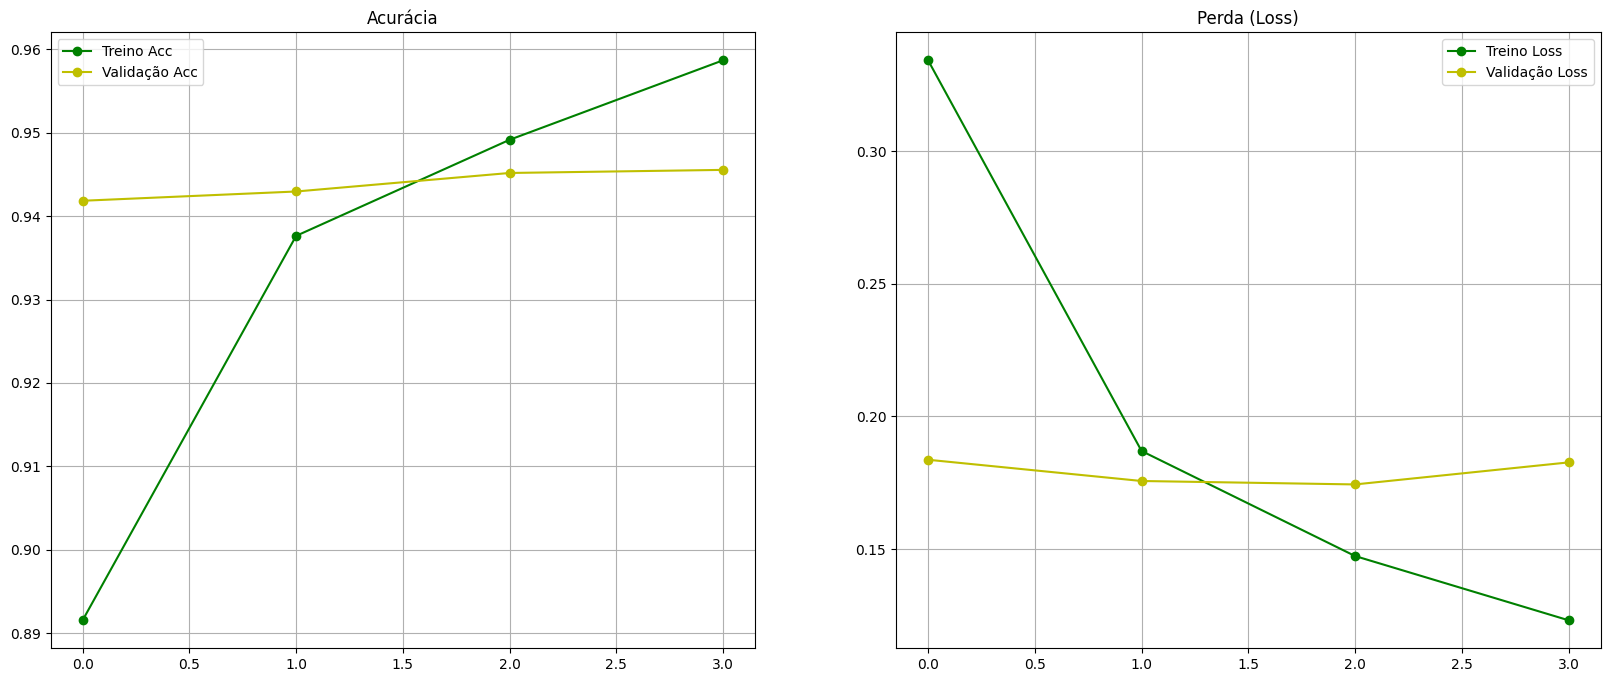

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Acurácia
ax[0].plot(history.history['accuracy'], 'go-', label='Treino Acc')
ax[0].plot(history.history['val_accuracy'], 'yo-', label='Validação Acc')
ax[0].set_title('Acurácia')
ax[0].legend()
ax[0].grid(True)

# Loss
ax[1].plot(history.history['loss'], 'go-', label='Treino Loss')
ax[1].plot(history.history['val_loss'], 'yo-', label='Validação Loss')
ax[1].set_title('Perda (Loss)')
ax[1].legend()
ax[1].grid(True)

plt.show()

Gerando previsões para a Matriz de Confusão...
85/85 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step


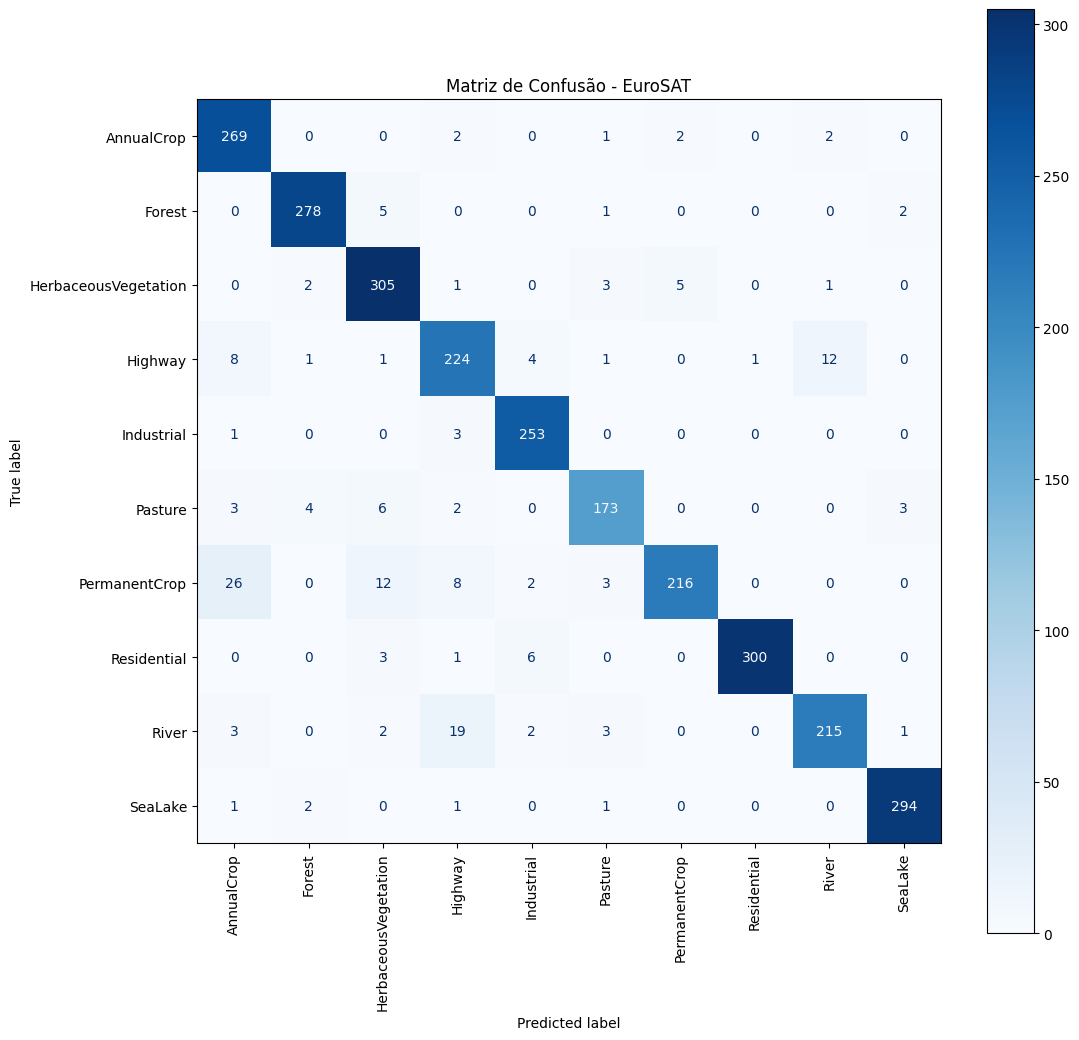

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Obter previsões e gabarito (Ground Truth)
print("Gerando previsões para a Matriz de Confusão...")

# O model.predict retorna as probabilidades para todo o dataset de teste
y_probs = model.predict(test_ds) 

# Convertemos probabilidades em números inteiros (0 a 9) pegando o maior valor
y_pred = np.argmax(y_probs, axis=1)

# Precisamos extrair os rótulos reais do dataset (test_ds) na mesma ordem
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 2. Criar e Plotar a Matriz
fig, ax = plt.subplots(figsize=(12, 12))

# Cria a matriz comparando Real vs Predito
cm = confusion_matrix(y_true, y_pred)

# Plota visualmente
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical', values_format='d')

plt.title("Matriz de Confusão - EuroSAT")
plt.show()